In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler, scale
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from numpy import logspace
import pickle
from scipy.stats import rankdata

import shap

from sklearn.ensemble import RandomForestRegressor
import TraitData
from imp import reload
import seaborn as sns
reload(TraitData)
sns.set()
sns.set(font_scale=1.5)

# try:
#     SAVED_STATE = pickle.load(open("np.random.state", 'rb'))
#     np.random.set_state(SAVED_STATE)
# except Exception as e:
#     SAVED_STATE = False
    

%matplotlib inline
plt.rcParams['figure.figsize'] = (7,15)
%config InlineBackend.figure_format = 'retina'

<img style="float:right" src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" width=60px)/>
<h1> Feature Interpretation Across Methods: A Study <small> Tony Cannistra | CSE546 Au17 Final Project </small></h1>
We are attempting to understand the type and magnitude of the effects that various physiological or behavioral traits have had on historical range shifts.

The challenge is that standard linear regression has been only able to explain a small percentage of the variance seen in range shift data for several taxa ([Angert et al., 2011](http://onlinelibrary.wiley.com/doi/10.1111/j.1461-0248.2011.01620.x/abstract)). This is likely as a result of the relationships between predictor and response variables being something other than linear, especially since several variables have biological relevance for their ability to facilitate range shifts. 

## Load Data + Define Functions
For this exploration we have trait data for several large taxonomic groups of organisms and their observed range shifts over the past 100 years. There are 3 datasets
### Define Each Dataset

In [2]:
plantsData = {
    'file' : "../data/angert_etal_2011/plants5.csv",
    
    'responseVar'   : "migration_m",

    'drop_features' : ["Taxon",
                     "migr_sterr_m", 
                     "shift + 2SE", 
                     'signif_shift',
                     "signif_shift2",
                     "dispmode01",
                     "DispModeEng", ## what is this
                     "shift + 2SE", 
                      "Grime"],
    'categorical_features' : ["oceanity",
                            "dispersal_mode",
                            "BreedSysCode"]
}

mammalData = {
    'file' : "../data/angert_etal_2011/mammals01.csv",
    
    'responseVar'   : "High_change",

    'drop_features' : ["Taxon",
                       "High_change_pfa2",
                       "Daily_rhythm_code",
                       "Annual_rhythm_code"],
    
    'categorical_features' : ["Daily01",
                              "Annual01",
                              "Food01",
                              "Daily_rhythm",
                              "Annual_rhythm",
                              "Food"]
}

rankings = []
MSEs = []


### Select, Load, and Normalize Dataset

In [3]:
dataset = mammalData
dropNA  = 0

td = TraitData.TraitData(dataset['file'],
                         dataset['responseVar'],
                         dataset['drop_features'],
                         dataset['categorical_features'],
                         dropNA=dropNA, scale=True)

print(len(td.X))
display(td.X.head())
td.X = np.array(td.X)

print(td.X.shape)
print(td.feature_names)



28


/Users/tony/miniconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
/Users/tony/miniconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


,Orig_high_limit,Litter_size,Litters_per_yr,Young_per_yr,Mass_g,Longevity_yrs,Bio1_mean,Bio1_std,Rangesize_km2,Food_code,...,Daily_rhythm_both,Daily_rhythm_diur,Daily_rhythm_noct,Annual_rhythm_fachib,Annual_rhythm_nonhib,Annual_rhythm_oblhib,Food_gran,Food_herb,Food_inse,Food_omni
0,-1.780427,-0.509175,0.210725,-0.385922,-0.305936,-0.658218,1.336065,-1.570086,-0.674237,1,...,-0.688247,-0.745356,1.452966,-0.408248,0.688247,-0.466252,1,0,0,0
1,-1.659520,-1.527525,0.210725,-0.578884,-0.251574,0.944400,1.218911,-0.709853,-0.690925,1,...,-0.688247,-0.745356,1.452966,-0.408248,0.688247,-0.466252,1,0,0,0
2,0.876267,0.509175,-0.969334,-0.578884,5.100035,2.547019,-1.124162,0.711794,-0.089662,2,...,-0.688247,1.341641,-0.688247,-0.408248,-1.452966,2.144761,0,1,0,0
3,-1.512470,1.527525,2.570843,3.087380,-0.263654,-1.058873,1.113095,-1.153552,-0.604368,2,...,1.452966,-0.745356,-0.688247,-0.408248,0.688247,-0.466252,0,1,0,0
4,0.804376,-0.509175,1.390784,0.771845,-0.257614,-1.058873,-0.202050,0.892895,0.750643,2,...,1.452966,-0.745356,-0.688247,-0.408248,0.688247,-0.466252,0,1,0,0


(28, 26)
['Orig_high_limit', 'Litter_size', 'Litters_per_yr', 'Young_per_yr', 'Mass_g', 'Longevity_yrs', 'Bio1_mean', 'Bio1_std', 'Rangesize_km2', 'Food_code', 'Daily01_0', 'Daily01_1', 'Annual01_0', 'Annual01_1', 'Food01_0', 'Food01_1', 'Daily_rhythm_both', 'Daily_rhythm_diur', 'Daily_rhythm_noct', 'Annual_rhythm_fachib', 'Annual_rhythm_nonhib', 'Annual_rhythm_oblhib', 'Food_gran', 'Food_herb', 'Food_inse', 'Food_omni']


In [4]:
pickle.dump(open('np.random.state', 'wb'), np.random.save_state())
X_train, X_test, Y_train, Y_test = train_test_split(td.X, td.Y, train_size=0.60)

## Learning

In [5]:
## Importance Plotting Function
def plot_importance(importances, names, title=None):
    f, ax = plt.subplots()
    bar_indices = np.arange(len(names))
    bar_width = 0.45
    importances_ind = np.argsort(abs(importances))

    plt.barh(bar_indices,
             importances[importances_ind],
            align='center', color='#4b2e83')


    plt.yticks(bar_indices, np.array(names)[importances_ind])
    plt.tight_layout()
    plt.title(title)
    plt.show()
    
def compute_ranks(importances, absolute=True):
    if absolute:
        sorted_idx =  abs(importances).argsort()[::-1]
    else:
        sorted_idx = importances.argsort()[::-1]
    return(np.arange(len(importances))[sorted_idx.argsort()])

### Linear Models
#### OLS

[  1.90250246 -12.81377065  -4.90875833  -1.74331559  -7.81610421
  -3.15264815  -6.82421162  -1.23088645   4.19079896  -6.91053191
  -0.99340404  -8.355824  ] 5    -0.069918
19   -0.069918
14   -0.069918
21    0.115471
27   -0.307216
1    -1.156299
4    -0.069918
24   -0.069918
6    -2.735815
16   -0.069918
22   -1.308318
26   -0.069918
Name: High_change, dtype: float64
38.6691830579


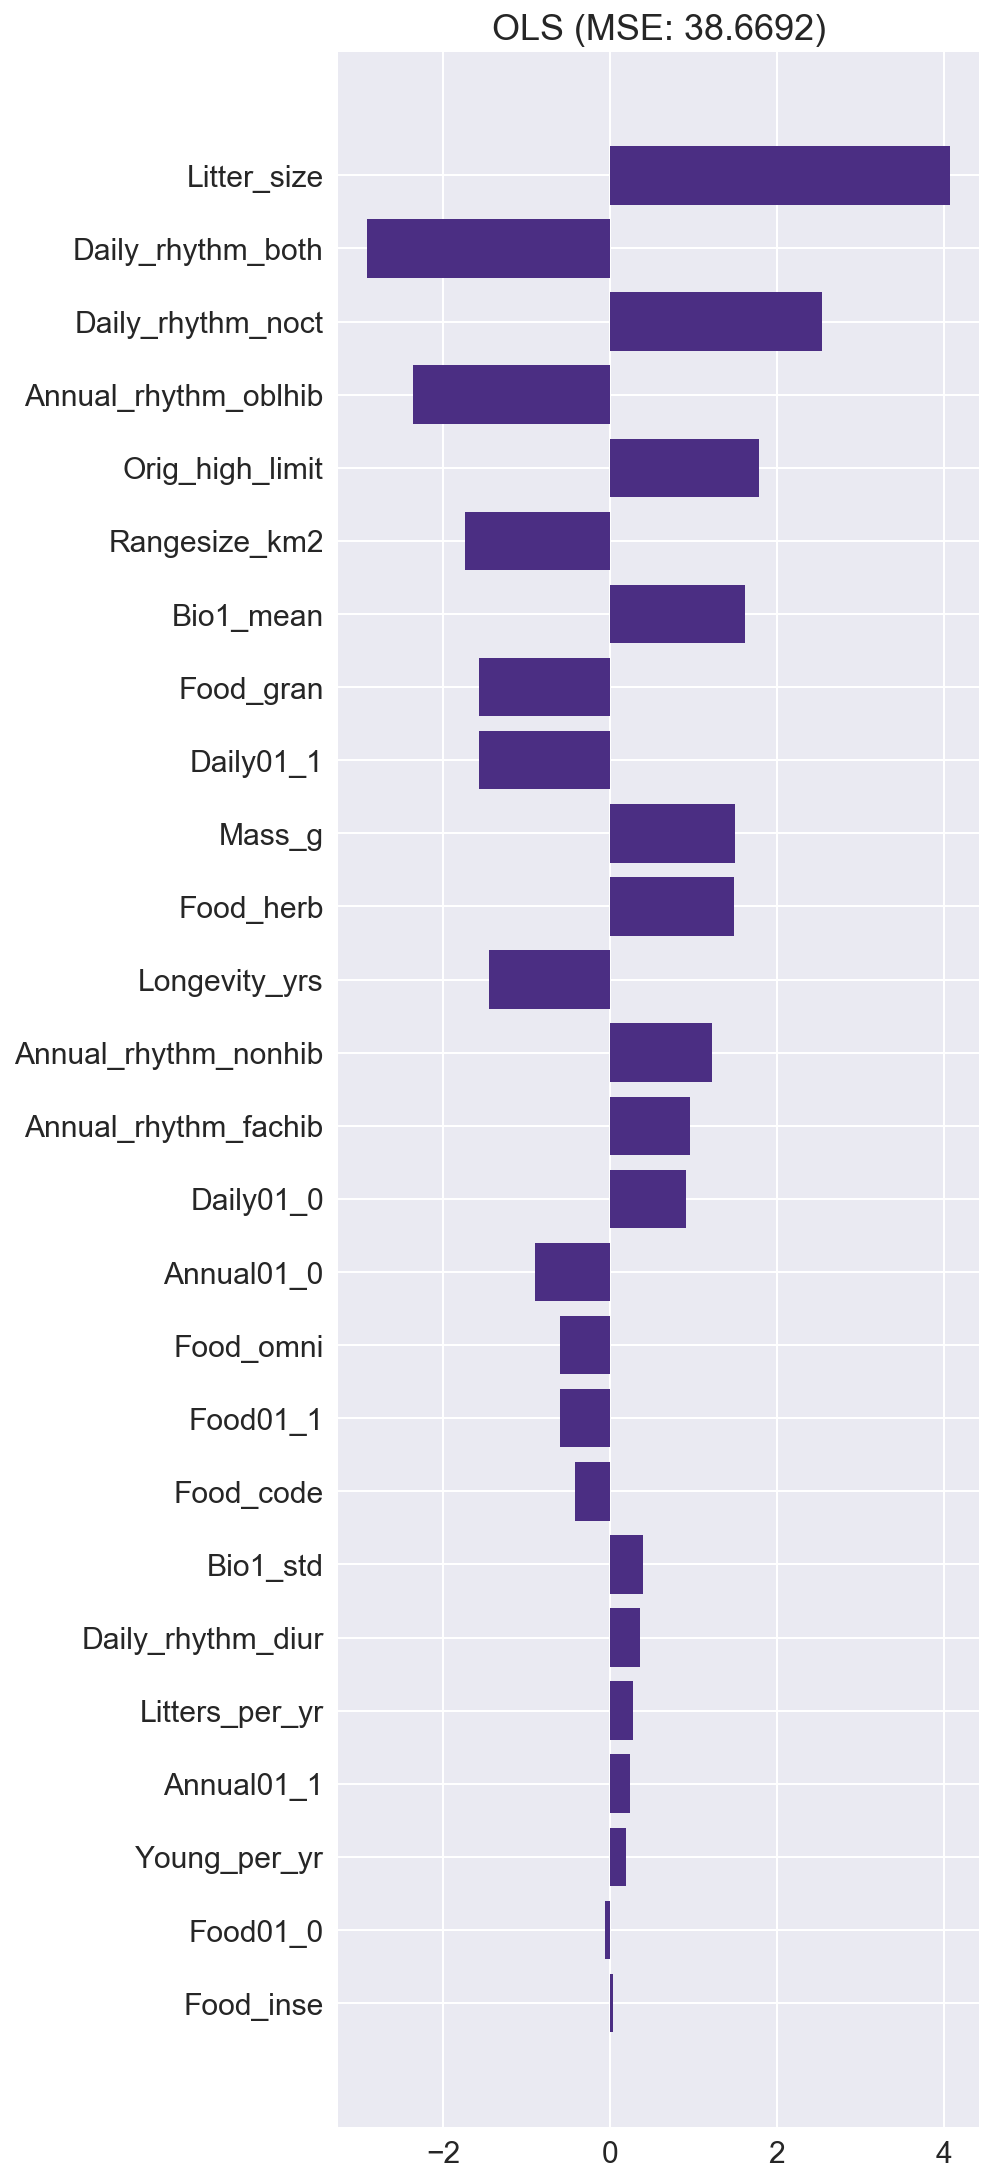

In [6]:

ols = LinearRegression(fit_intercept=False, normalize=False)
ols.fit(X_train, Y_train)
preds = ols.predict(X_test)
print(preds, Y_test)
error = mean_squared_error(Y_test, preds)
print(error)
plot_importance(ols.coef_, td.feature_names, "OLS (MSE: %1.4f)" % error)
MSEs.append(("OLS", error))
rankings.append(['OLS'] + list(compute_ranks(ols.coef_)))

#### Ridge CV

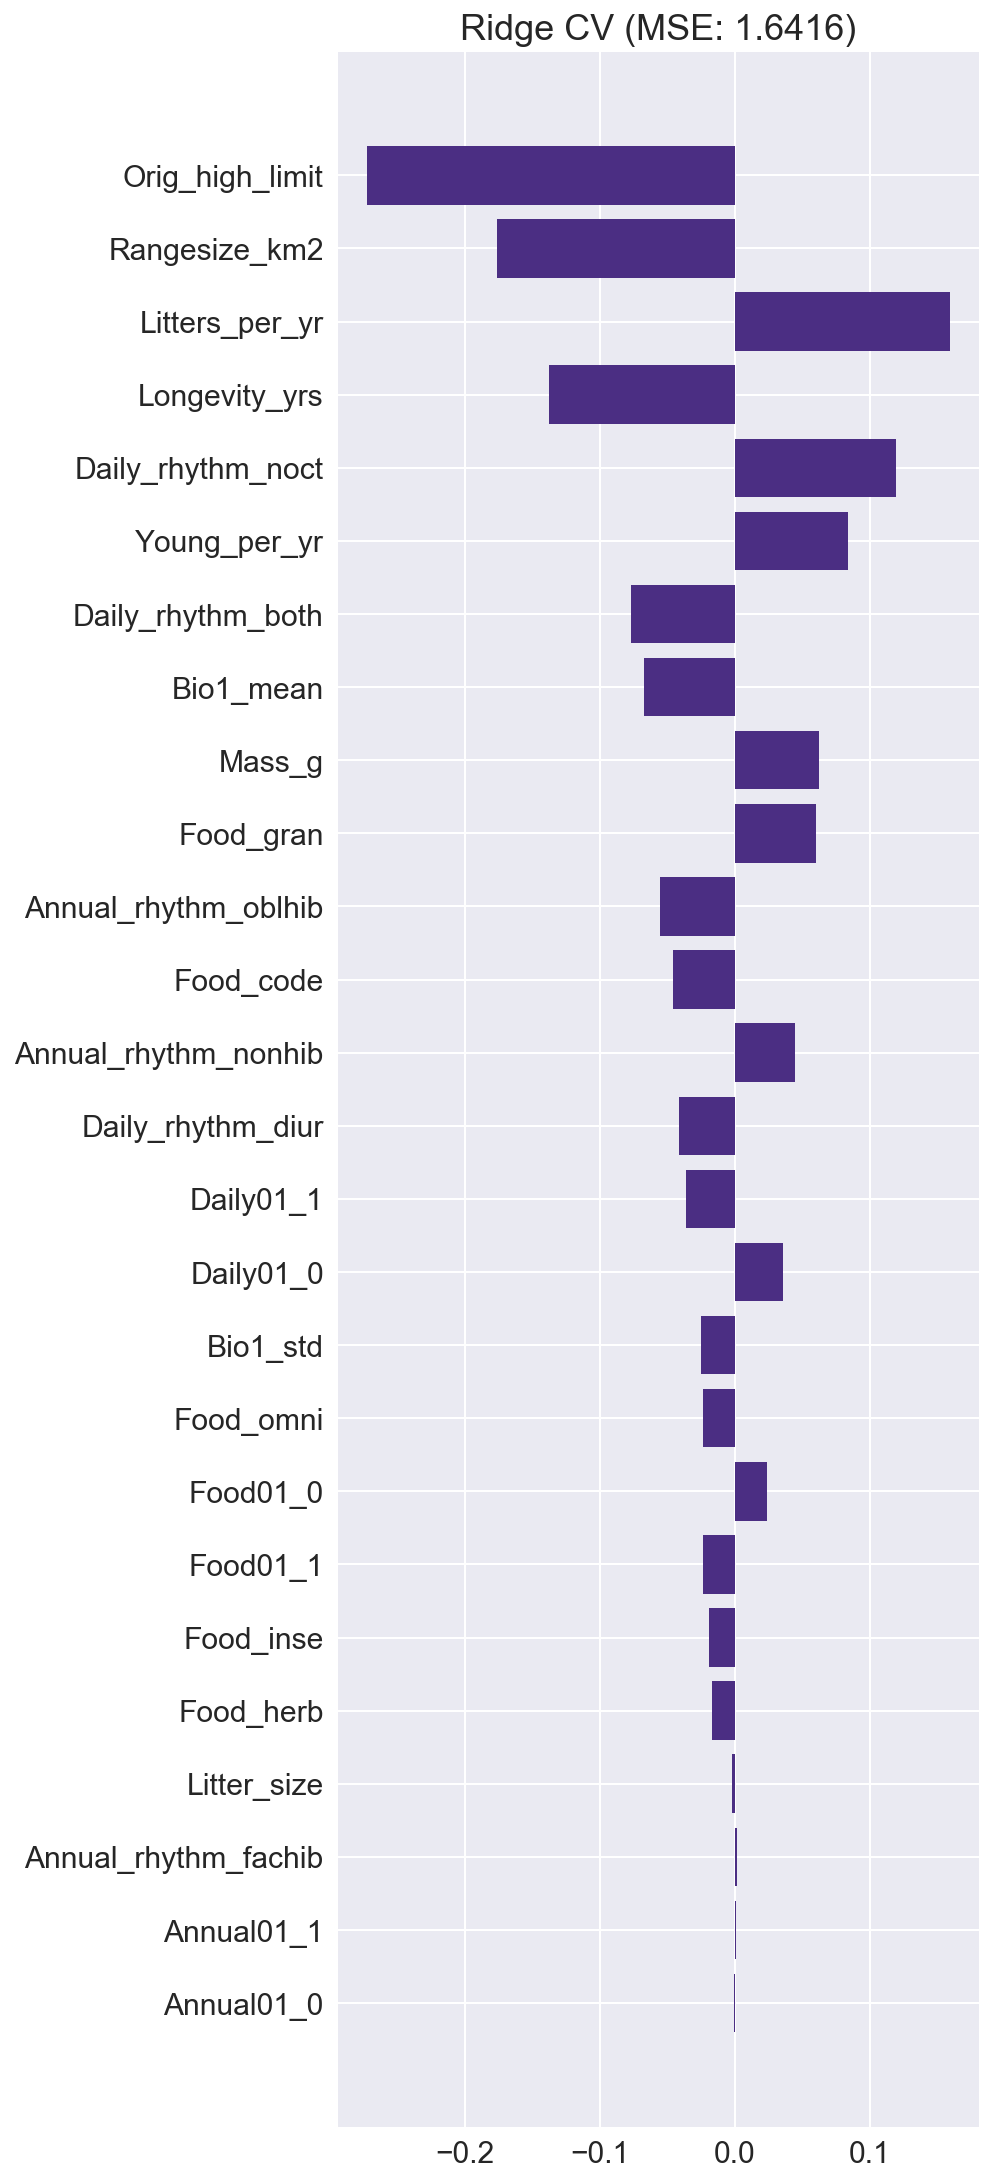

In [7]:
ridgecv = RidgeCV(normalize=False)
ridgecv.fit(X_train, Y_train)
preds = ridgecv.predict(X_test)
error = mean_squared_error(Y_test, preds)
MSEs.append(("Ridge", error))

plot_importance(ridgecv.coef_, td.feature_names,  "Ridge CV (MSE: %1.4f)" % error)
rankings.append(['Ridge'] + list(compute_ranks(ridgecv.coef_)))

#### Kernel Ridge

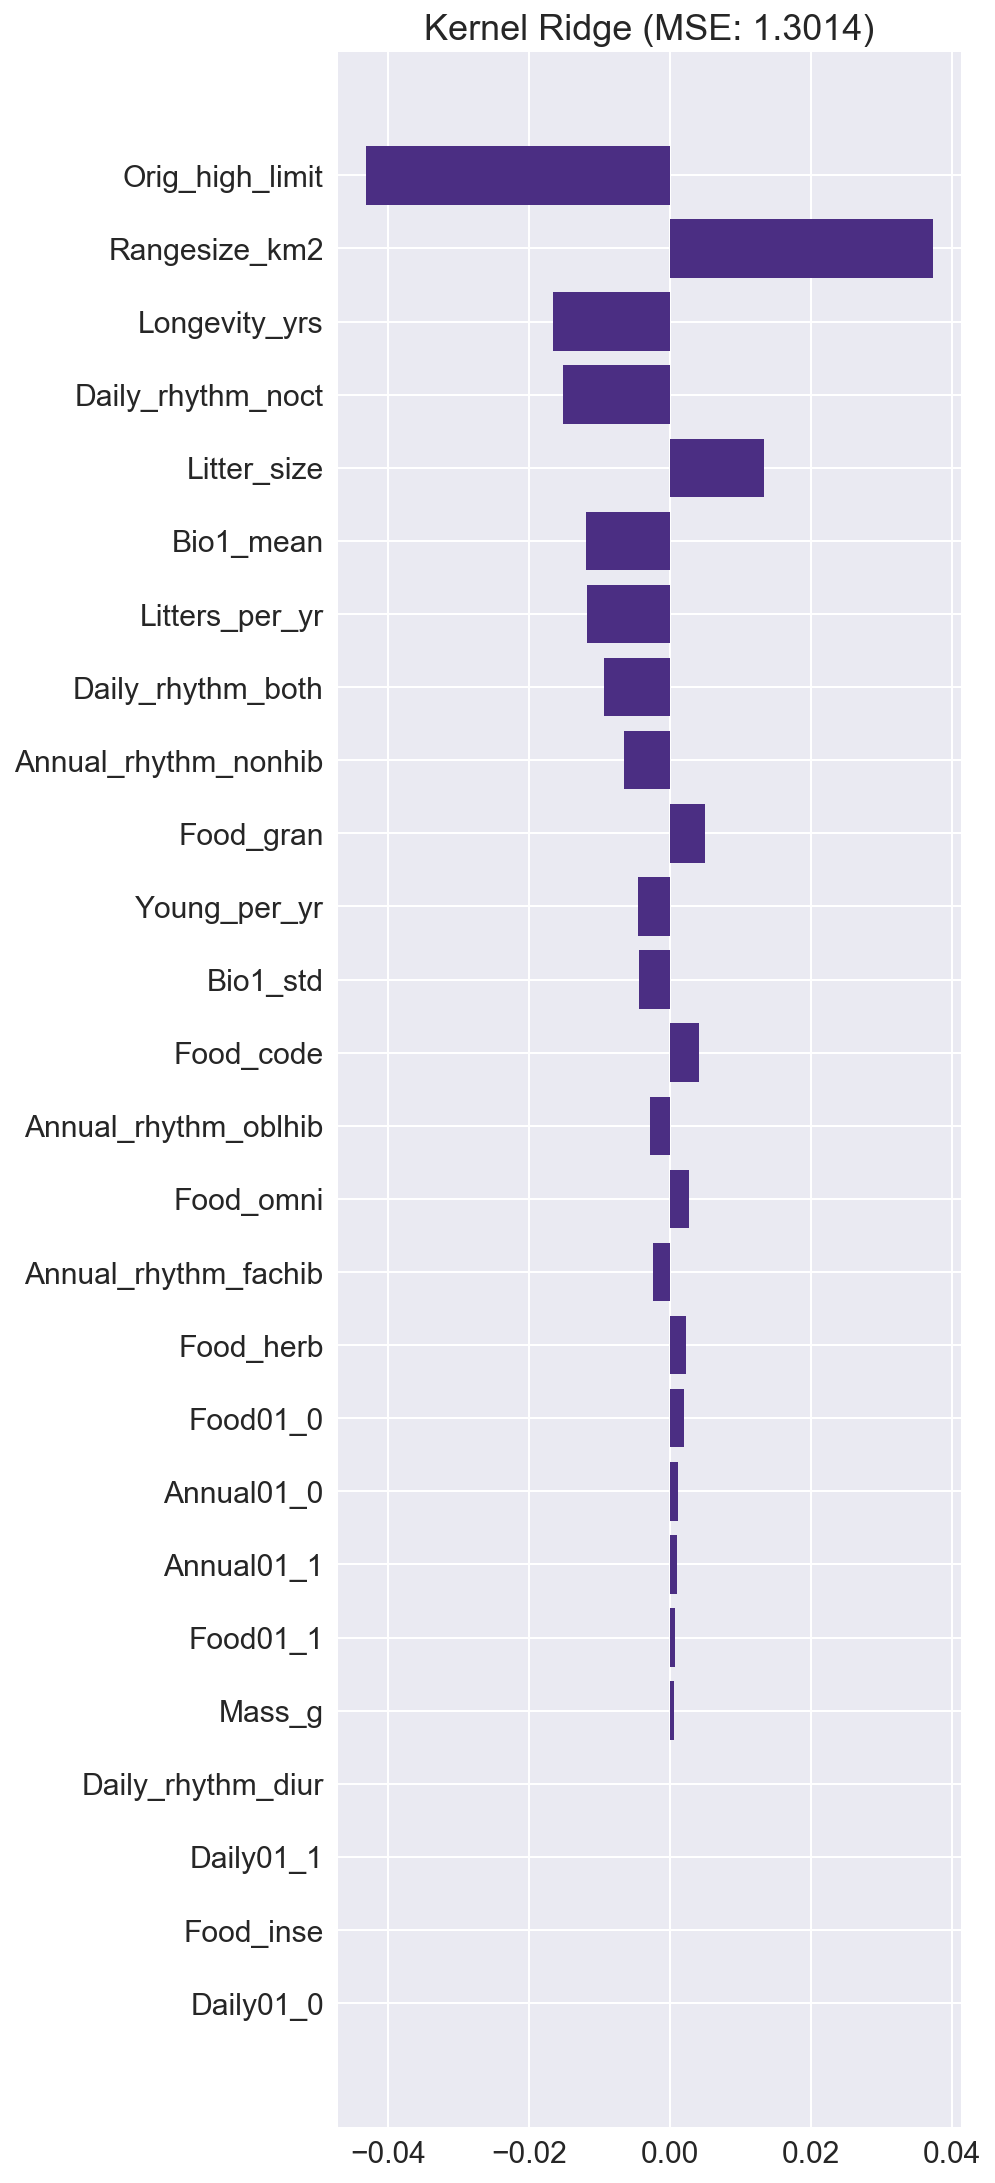

In [8]:
kr = KernelRidge(kernel='rbf')
kr.fit(X_train, Y_train)
preds = kr.predict(X_test)
error = mean_squared_error(Y_test, preds)
#plot_importance(kr.coef_, td.feature_names,  "Lasso CV (MSE: %1.4f)" % error)
shapdata = shap.DenseData(X_train, td.feature_names)
explainer = shap.KernelExplainer(kr.predict, shapdata, nsamples=100)
explanations =[]
for i in range(0, len(X_test)-1):
    try: 
        explanations.append(explainer.explain(np.mat(X_test[i:i+1, :])))
    except Exception as e:
        print("error on ", (i, i+1))
        print(e)
        continue

importances = np.mean(np.array([exp.effects for exp in explanations]), axis=0)
plot_importance(importances, td.feature_names, "Kernel Ridge (MSE: %1.4f)" % error)
MSEs.append(("Kernel Ridge", error))

rankings.append(['Kernel Ridge'] + list(compute_ranks(importances)))

### Trees

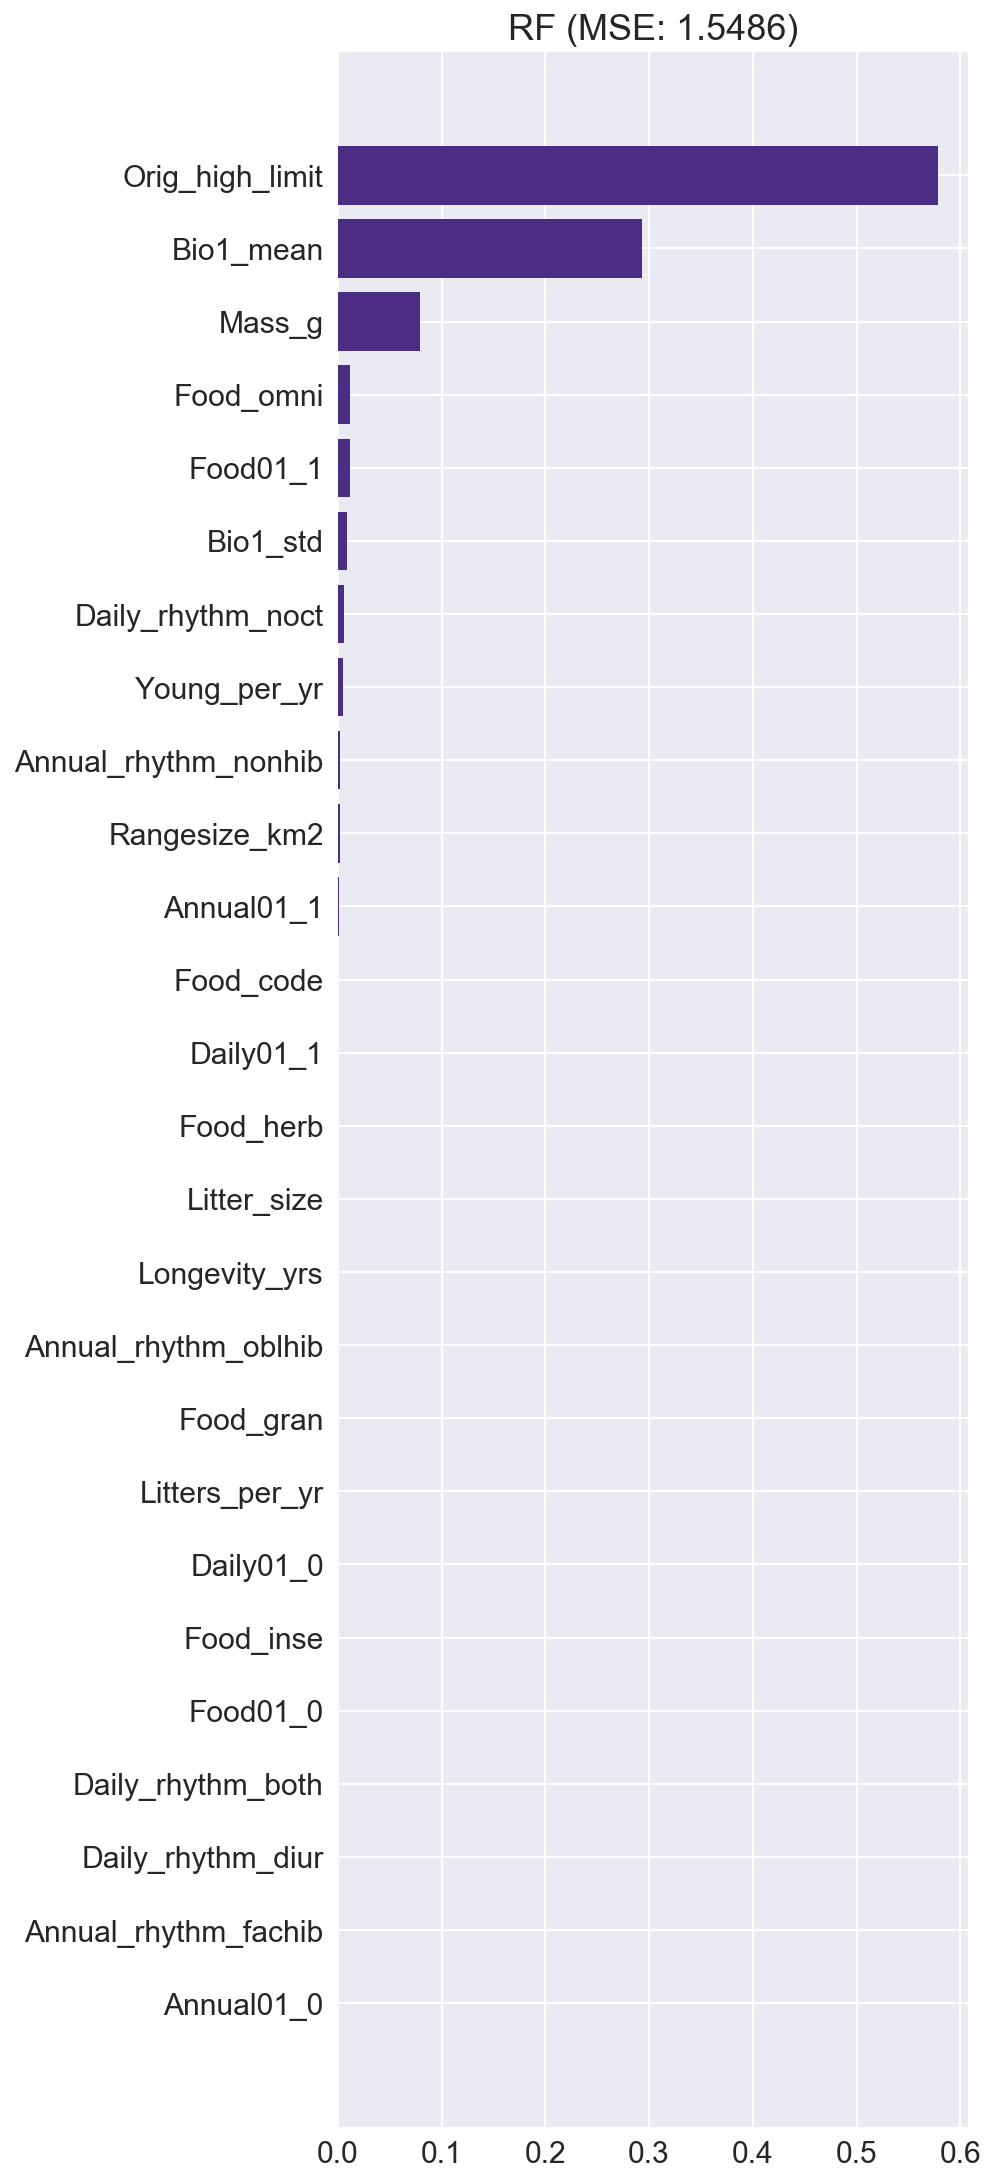

In [9]:
rf = RandomForestRegressor()
rf.fit(X_train, Y_train)
preds = rf.predict(X_test)
error = mean_squared_error(Y_test, preds)
MSEs.append(("RF", error))

plot_importance(rf.feature_importances_, td.feature_names, "RF (MSE: %1.4f)" %error)
rankings.append(['RF'] + list(compute_ranks(rf.feature_importances_)))

### Support Vectors

In [10]:
baseModel = SVR()
params_grid = {
    'C'     : np.logspace(-3, 1.2),
    'gamma' : np.logspace(-3, 1.2),
    'degree': [0, 1, 2],
    'kernel': ['linear', 'poly', 'rbf']
}
gridSearch = GridSearchCV(baseModel,
                         param_grid = params_grid,
                         scoring="neg_mean_squared_error",
                         error_score = 0,
                         n_jobs = -1)
gridSearch.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score=0,
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-03,   1.21819e-03,   1.48398e-03,   1.80777e-03,
         2.20220e-03,   2.68270e-03,   3.26803e-03,   3.98107e-03,
         4.84969e-03,   5.90784e-03,   7.19686e-03,   8.76712e-03,
         1.06800e-02,   1.30103e-02,   1.58489e-02,   1.93070e-02,
         2.3519...    5.90784e+00,   7.19686e+00,   8.76712e+00,   1.06800e+01,
         1.30103e+01,   1.58489e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [11]:
best = gridSearch.best_estimator_

In [12]:
preds = gridSearch.best_estimator_.predict(X_test)
error = mean_squared_error(preds, Y_test)
print(error)
MSEs.append(("SVR", error))


0.96436590119


In [13]:
shap.initjs()
shapdata = shap.DenseData(X_train, td.feature_names)
explainer = shap.KernelExplainer(best.predict, shapdata, nsamples=100)
explanations =[]
for i in range(0, len(X_test)-1):
    try: 
        explanations.append(explainer.explain(np.mat(X_test[i:i+1, :])))
    except Exception as e:
        print("error on ", (i, i+1))
        print(e)
        continue

all_effects = pd.concat([pd.DataFrame(list(zip(exp.effects, td.feature_names))) for exp in explanations])


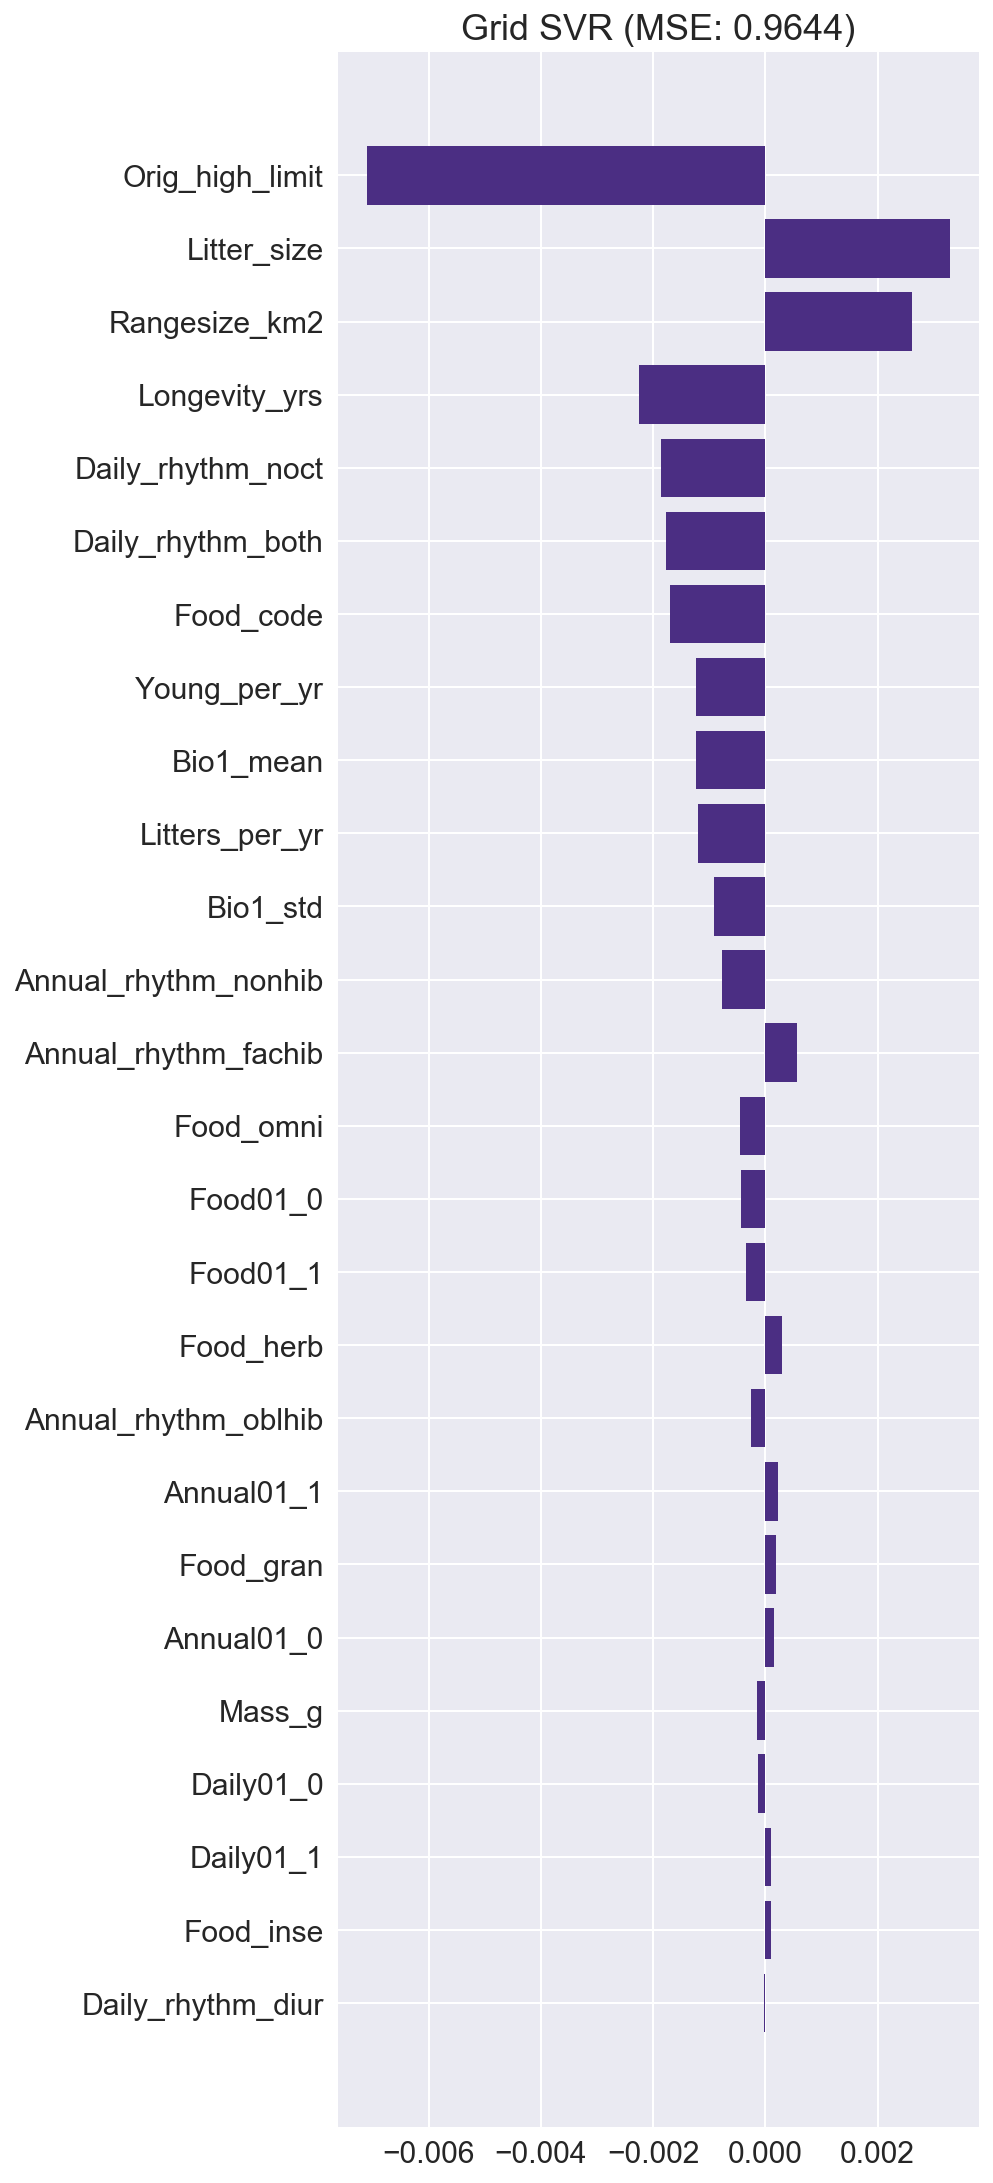

In [14]:
importances = np.mean(np.array([exp.effects for exp in explanations]), axis=0)
plot_importance(importances, td.feature_names, "Grid SVR (MSE: %1.4f)" % error)
rankings.append(['SVR'] + list(compute_ranks(importances)))

In [15]:
results = pd.DataFrame(rankings, columns=["Method"] + td.feature_names).set_index("Method").T
results['mean'] = results.mean(axis=1)


In [16]:
results.sort_values(by=['mean'])

Method,OLS,Ridge,Kernel Ridge,RF,SVR,mean
Orig_high_limit,4,0,0,0,0,0.8
Rangesize_km2,5,1,1,9,2,3.6
Daily_rhythm_noct,2,4,3,6,4,3.8
Bio1_mean,6,7,5,1,8,5.4
Longevity_yrs,11,3,2,15,3,6.8
Litter_size,0,22,4,14,1,8.2
Daily_rhythm_both,1,6,7,22,5,8.2
Annual_rhythm_nonhib,12,12,8,8,11,10.2
Young_per_yr,23,5,10,7,7,10.4
Litters_per_yr,21,2,6,18,9,11.2


In [17]:
from pandas.tools.plotting import table


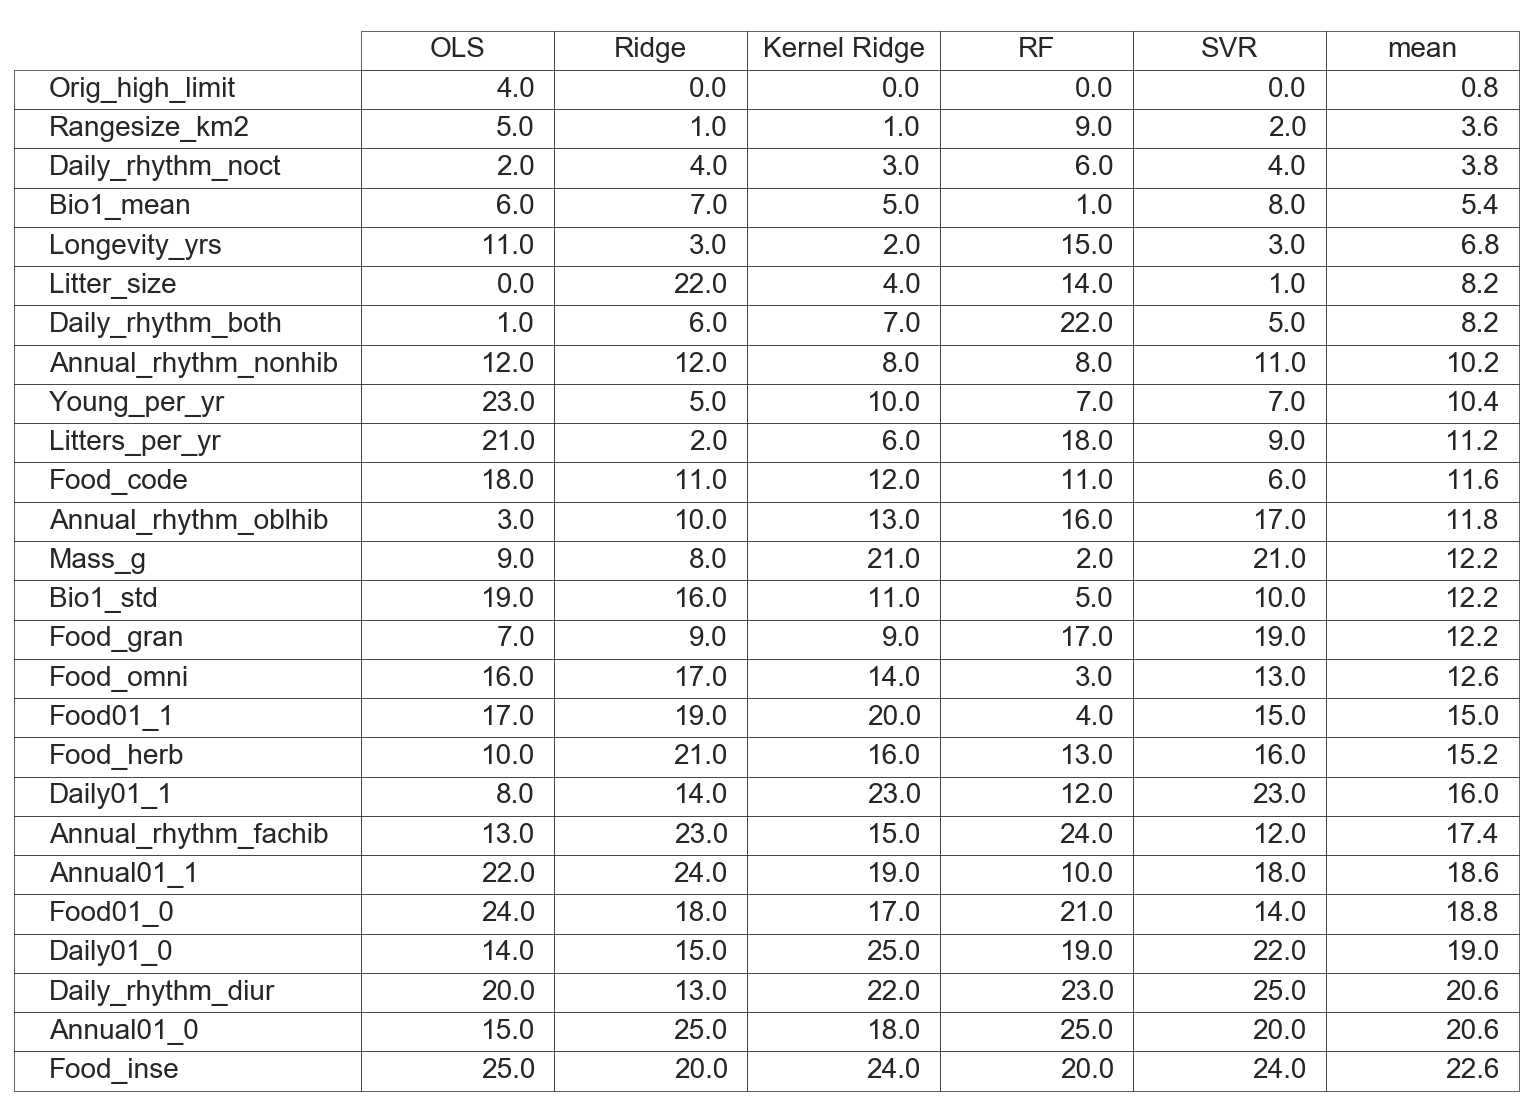

In [18]:
results = results.sort_values(by='mean')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
tab = table(ax, results, loc='upper left')
tab.auto_set_font_size(False)
tab.set_fontsize(14)
tab.scale(1.2, 1.3)
fig.tight_layout()

Text(0.5,1,'Model Performance Comparison')

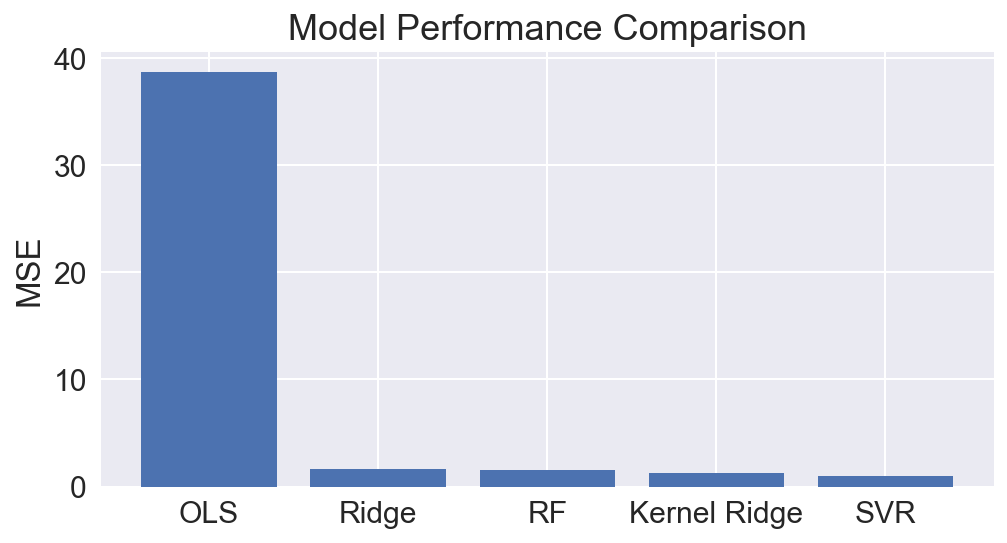

In [19]:

fig = plt.figure(figsize=(8, 4))
labels, errors = zip(*MSEs)
errors = np.array(errors)
labels = np.array(labels)
sorted_idx = np.argsort(errors)[::-1]
plt.bar(range(0, len(MSEs)), errors[sorted_idx])
plt.xticks(range(0, len(MSEs)), labels[sorted_idx])
plt.ylabel("MSE")
plt.title("Model Performance Comparison")